<a href="https://colab.research.google.com/github/He-ya/freeCodeCamp/blob/master/Lab_10_Bike_Sharing_%26_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 資料集介紹

#### **問題介紹**

腳踏車共享對於綠化城市，共享交通的重要性不在話下。也常常被稱為: 大眾運輸的最後一哩路。整個流程包括: 會員系統、租借、歸還等透過腳踏車站集結而成的路網系統。使用這個系統人們可以輕鬆地在甲地租借一台腳踏車並在乙地歸還，目前世界上已經有超過500個腳踏車共享計畫。在營運上為了要更好分配車輛以及做好後勤管理，我們想知道有沒辦法透過歷史數據來預測什麼樣的條件下會影響腳踏車租借的總數目。本資料集為Kaggle的 "Bike Sharing Demands"競賽的開放資料集。

#### **資料介紹**

* datetime - 日期時間
* season -  1234 = 春夏秋冬
* holiday - 假日
* workingday - 平日
* weather - 天氣
    * 1: 天晴無雲，部分有雲
    * 2: 霧有雲，少雲，有霧
    * 3: 小雨，小雨烏雲打雷，烏雲打雷
    * 4: 大雨，冰雹，雪，雷雨
* temp - 攝氏溫度
* atemp - 攝氏體感溫度
* humidity - 相對濕度
* windspeed - 風速
* casual - 非會員
* registered - 註冊會員
* count - 總共租車數目

In [0]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
from IPython.display import display
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

#### **讀資料集**
使用colab api 上傳檔案

In [0]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [0]:
dailyData = pd.read_csv("train.csv")  # 用pandas讀取資料

## 資料概要

第一步我們會對資料找出以下三件事

 - 資料的數目
 - 看資料的前五項或後五項
 - 資料由哪些種類構成

#### **資料集大小**

In [0]:
display(dailyData.describe())
display("資料大小: " + str(dailyData.shape))

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


'資料大小: (10886, 12)'

#### **資料的前五項**

In [0]:
display(dailyData.head())

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


#### **變數的種類**

In [0]:
display(dailyData.dtypes)

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

## 特徵工程

由上面可知，某幾列變數"季節，假日，平日和天氣"皆為分類數據。但在型別上都是"int"。我們必須先對這些變數做處理。

 - 由datetime創造新的列: "日期"，"小時"，"星期幾"，"月份"
 - 將季節，假日，平日，天氣轉成分類數據。
 - 因我們已經從datetime取出有用特徵，刪除此列。

#### **由datetime取出有用特徵**

In [0]:
dailyData["date"] = dailyData.datetime.apply(lambda x : x.split()[0])  # apply() - 對該列所有資料進行()內的函數
dailyData["hour"] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0])
dailyData["weekday"] = dailyData.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dailyData["month"] = dailyData.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
dailyData["season"] = dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
dailyData["weather"] = dailyData.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

#### **轉換成類別數據**

In [0]:
categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype("category")

#### **捨去不需要的列**

In [0]:
dailyData  = dailyData.drop(["datetime"],axis=1)

## 缺漏資料分析

一但我們掌握了資料縱軸(數量)橫軸(屬性)後，通常接下來我們會想知道有沒有任何缺漏資料。幸運地在這個資料集裡面沒有。這裡推薦使用missingno以圖像化的方式來分析缺漏資料。


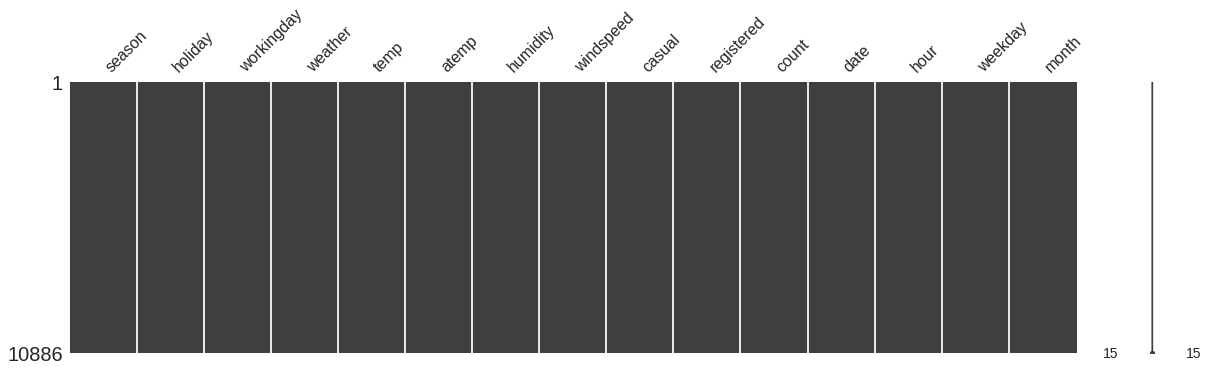

In [0]:
msno.matrix(dailyData,figsize=(20,5))

## 異常資料分析

使用Boxplots針對每一變數做分析可以作出以下推論:

 - 春季有相對少的租借數量。
 - 每天小時的 boxplot有以下有趣現象: 中位數在早上七點到八點間和下午五六點間偏高，可推論是上班族與學生通勤使用
 - 由圖四可看出多半偏離值發生在平日。

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


[Text(0,0.5,'Count'),
 Text(0.5,0,'Working Day'),
 Text(0.5,1,'Box Plot On Count Across Working Day')]

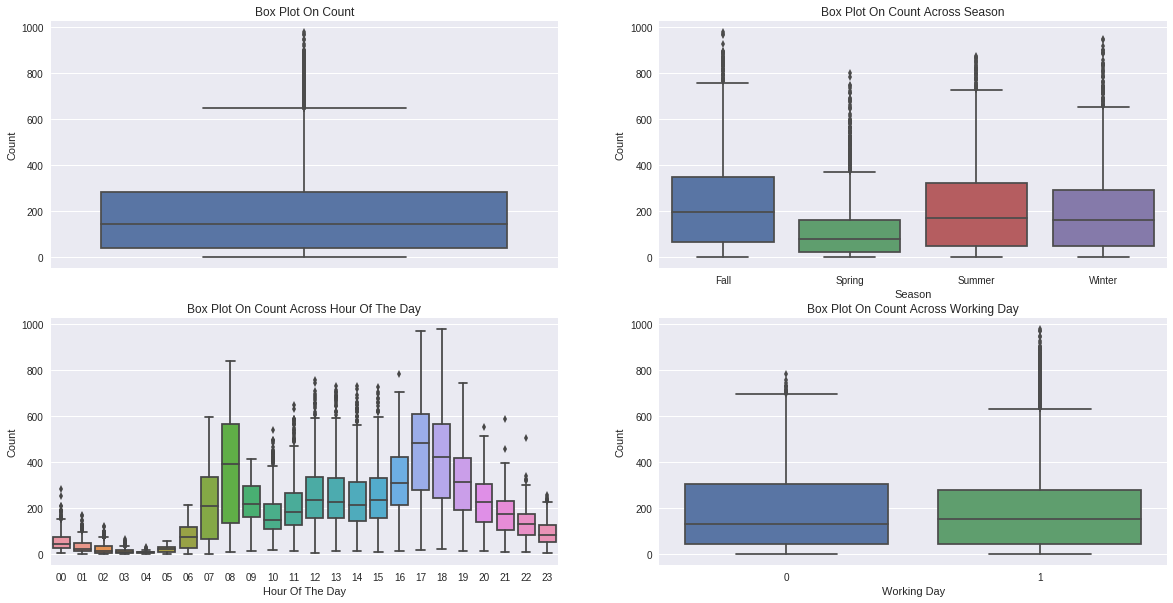

In [0]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20, 10)
sn.boxplot(data=dailyData,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=dailyData,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=dailyData,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=dailyData,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

#### **將count部分的偏離值移除**

In [0]:
dailyDataWithoutOutliers = dailyData[np.abs(dailyData["count"]-dailyData["count"].mean())<=(3*dailyData["count"].std())] 

In [0]:
print ("Shape Of The Before Ouliers: ",dailyData.shape)
print ("Shape Of The After Ouliers: ",dailyDataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (10886, 15)
Shape Of The After Ouliers:  (10739, 15)


## 關聯性分析

EDA中一個必做的就是了解任一變數是怎麼和其他特徵相依。通常用的方法是計算出所有特徵之間的關聯性矩陣。以下我們顯示["count, "temp","atemp","humidity","windspeed"]

此處我們使用pandas內建的corr()計算。

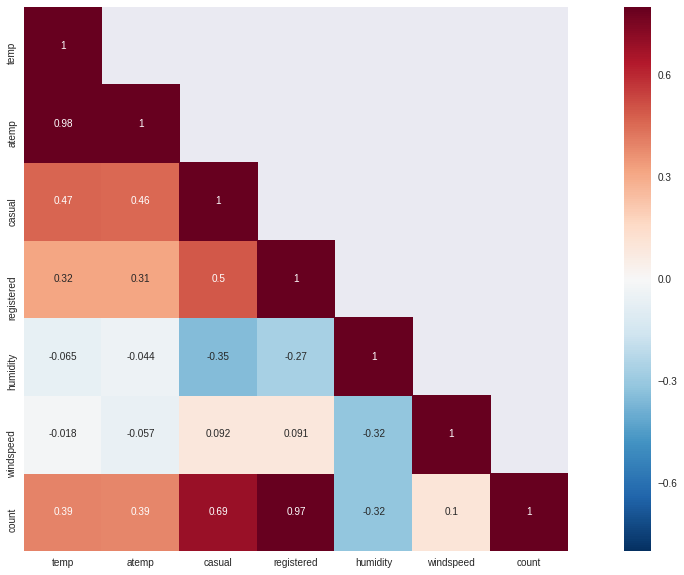

In [0]:
corrMatt = dailyData[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

## Count Vs (Month,Season,Hour,Weekday,Usertype)的視覺化

 - 人們常常在夏天租腳踏車，可以看出六月七月八月有相對高的需求。
 - 平日通勤時間需求明顯上升
 - 在六日以上不太明顯。
 - 早上七八點與下午五六點通常都是已註冊使用者租借居多。

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


[Text(0,0.5,'Users Count'),
 Text(0.5,0,'Hour Of The Day'),
 Text(0.5,1,'Average Users Count By Hour Of The Day Across User Type'),
 None]

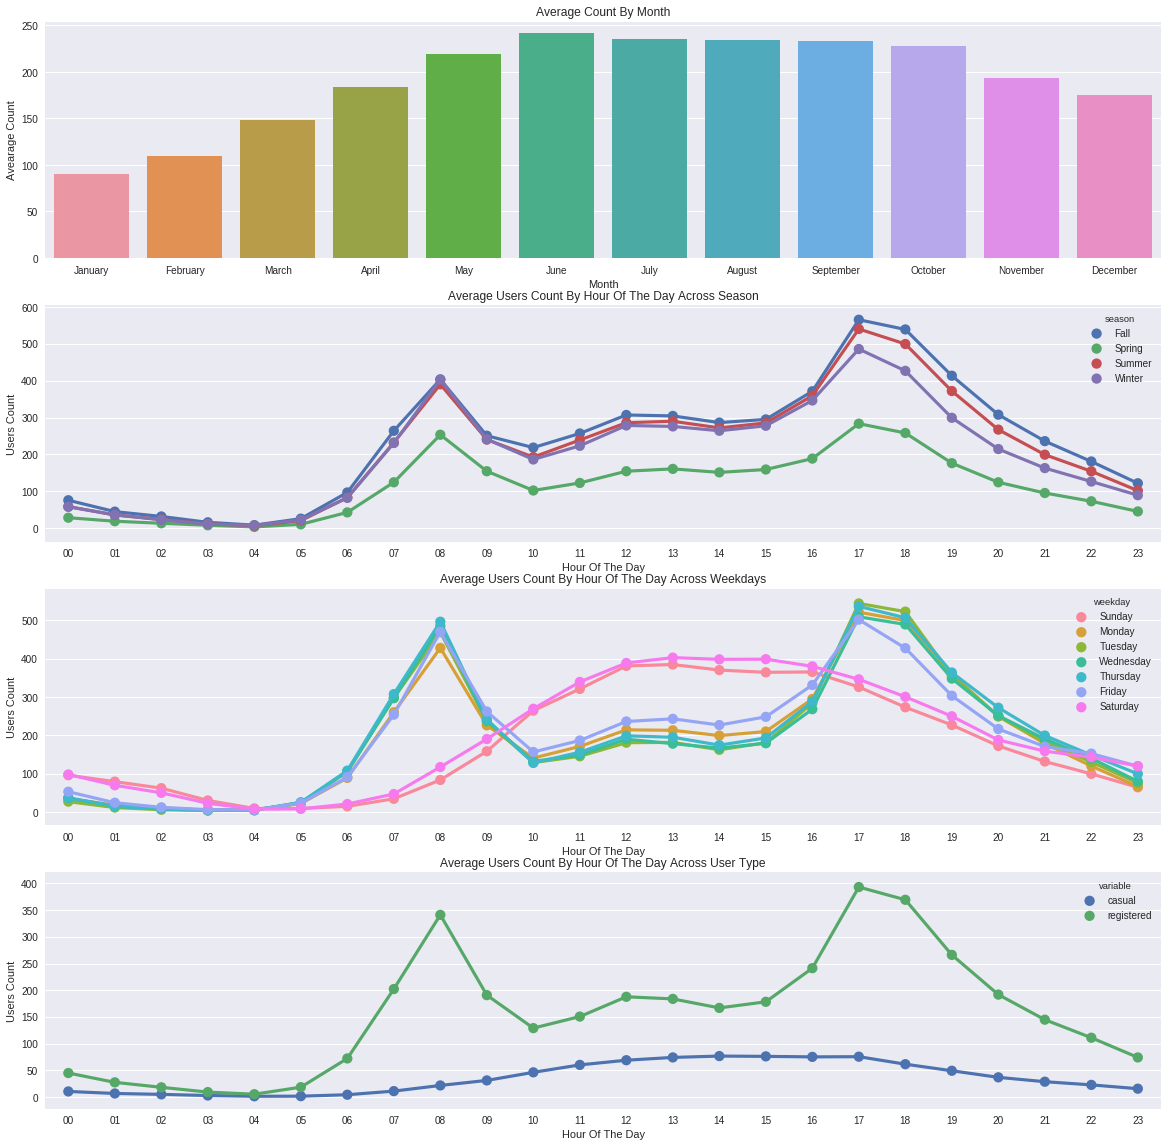

In [0]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(20,20)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(dailyData.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sn.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(dailyData[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

**以下處理測試與訓練資料**

In [0]:
dataTrain = pd.read_csv("train.csv")
dataTest = pd.read_csv("test.csv")
data = dataTrain.append(dataTest)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

**特徵工程**

In [0]:
data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)
dataWindspeedOriginal = data["windspeed"]

**針對風速做特徵工程處理**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[Text(0,0.5,'Count'),
 Text(0.5,0,'Windspeed Values'),
 Text(0.5,1,'Count Of Windspeed Values Before Imputing'),
 None]

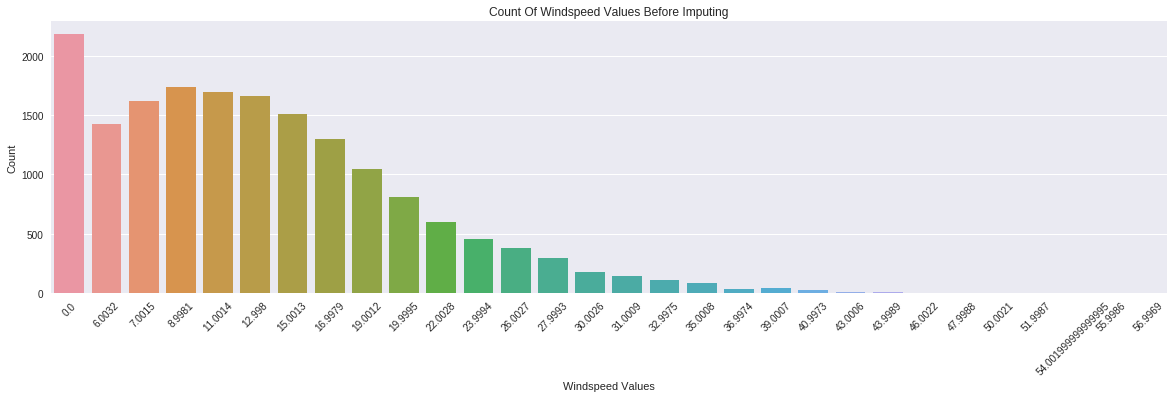

In [0]:
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
windspeed = pd.DataFrame(data.windspeed.value_counts()).reset_index()
plt.xticks(rotation=45) 
sn.barplot(data=windspeed,x="index",y="windspeed",ax=ax)
ax.set(xlabel='Windspeed Values', ylabel='Count',title="Count Of Windspeed Values Before Imputing",label='big')

**使用RandomForest預測風速**

In [0]:
from sklearn.ensemble import RandomForestClassifier

windColumns = ["season","weather","humidity","month","temp","year","atemp"]
dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"]!=0]
dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

rfModel_wind = RandomForestClassifier()  ## 這邊使用隨機樹分類器做預測
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])
wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])

dataWind0["windspeed"] = wind0Values
data = dataWindNot0.append(dataWind0)
data["windspeed"] = data["windspeed"].astype("float")
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


**把風速做特徵工程處理後的分佈**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[Text(0,0.5,'Count'),
 Text(0.5,0,'Windspeed Values'),
 Text(0.5,1,'Count Of Windspeed Values After Imputing'),
 None]

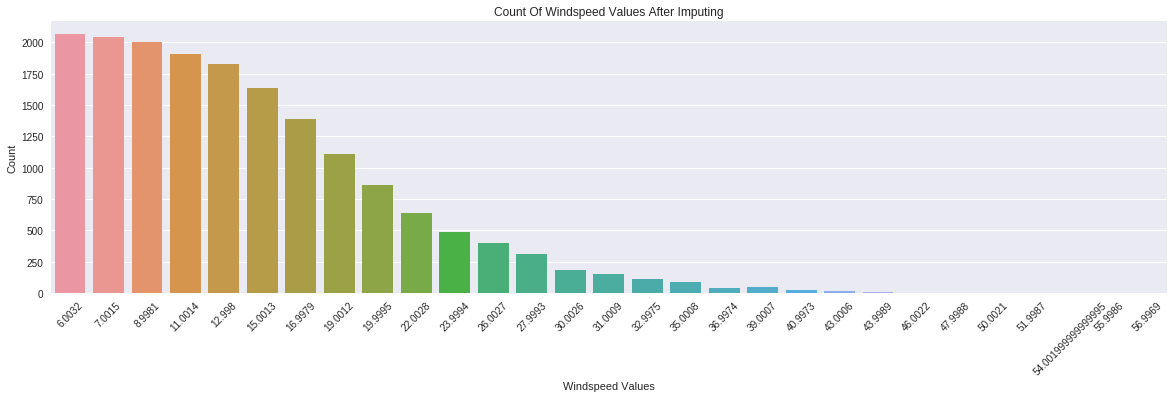

In [0]:
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
windspeed = pd.DataFrame(data.windspeed.value_counts()).reset_index()
plt.xticks(rotation=45) 
sn.barplot(data=windspeed,x="index",y="windspeed",ax=ax)
ax.set(xlabel='Windspeed Values', ylabel='Count',title="Count Of Windspeed Values After Imputing",label='big')

**強制將int轉成categorical**

In [0]:
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"count","datetime","date","registered"]

for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

**將data藉由有無count分成train和test資料集**

In [0]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
# yLablesRegistered = dataTrain["registered"]
# yLablesCasual = dataTrain["casual"]

**將train資料切出validation**

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split( dataTrain, yLabels, test_size=0.3, random_state=42)
dateTimeColValidate = X_validate["datetime"]

**清理變數**

In [0]:
dataTrain  = dataTrain.drop(dropFeatures,axis=1)
dataTest  = dataTest.drop(dropFeatures,axis=1)
X_train = X_train.drop(dropFeatures,axis=1)
X_validate = X_validate.drop(dropFeatures,axis=1)

**RMSLE 是競賽所用計分方式，以下直接提供公式算法**

In [0]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [0]:
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

## **使用Linear Regression作count預測** ##

In [0]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
lModel.fit(X = X_train,y = np.log1p(y_train))

# Make predictions
preds = lModel.predict(X= X_validate)
print ("RMSLE Value For Linear Regression In Validation: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds),False))


RMSLE Value For Linear Regression In Validation:  0.9829798667251745


## **Ensemble Models - Random Forest** ##

使用組合機不但可以得到較好結果，且樹類型(tree-based)的組合機(如random forest)可得到特徵重要性(features importance)

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rfModel = RandomForestRegressor(n_estimators=100) ### Test 0.44
rfModel.fit(X = X_train,y = np.log1p(y_train))
preds = rfModel.predict(X= X_validate)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds),False))

RMSLE Value For Random Forest:  0.2835859825062333


**Random Forest 的特徵重要性**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


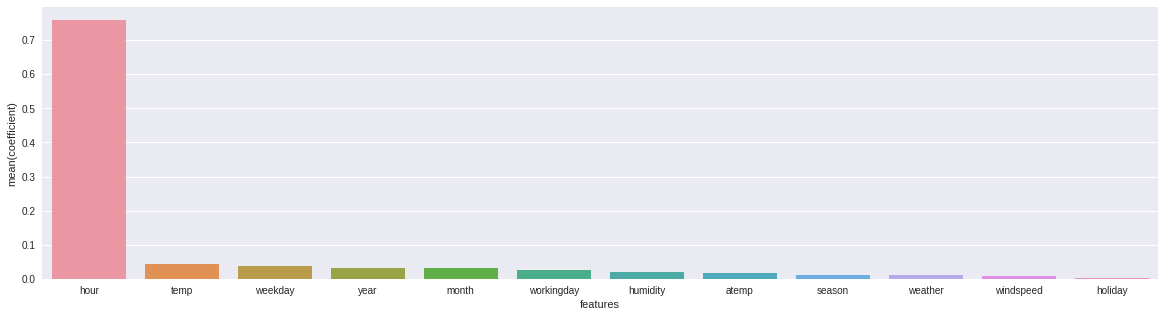

In [0]:
features = pd.DataFrame()
features['features'] = X_train.columns
features['coefficient'] = rfModel.feature_importances_
features.sort_values(by=['coefficient'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sn.barplot(data=features,x="features",y="coefficient",ax=ax)

In [0]:
#submission = pd.DataFrame({
#        "datetime": datetimecol,
#        "count": [max(0, x) for x in np.exp(predsTest)]
#    })
#submission.to_csv('bike_prediction_output.csv', index=False)

**The submission will have test score of 0.41**